# Gradient descent y Tensorboard

## Configuración y carga de datos

In [39]:
import datetime, os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()

import tensorflow_probability as tfp


tb_logs_dir = "./logs/"
os.makedirs(tb_logs_dir, exist_ok=True)

%load_ext tensorboard
# %tensorboard --logdir {tb_logs_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


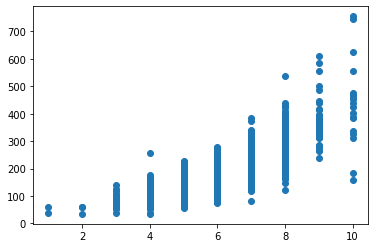

In [17]:
all_data = np.load('data/proyecto_training_data.npy')

training_y = all_data[:,0].reshape(-1,1) / 1000 # precio de venta en miles de dólares
training_x = all_data[:,1].reshape(-1,1)
n_sample = len(training_y)

plt.scatter(training_x, training_y)
plt.show()

## Formulación de hipótesis

Verificamos que las variables presentan un coeficiente de correlación positivo y considerablemente alto. Esto nos indica que un modelo de regresión lineal podría ajustarse a los datos.

In [18]:

corr = tfp.experimental.substrates.numpy.stats.correlation(np.copy(training_x), np.copy(training_y))
print(corr)

[[0.7909816]]


## Definicion de grafo

In [34]:
class Model:
    def __init__(self, training_x, training_y, learning_rate):
        with tf.name_scope("datos_de_entrenamiento"):
            self.x = tf.concat([training_x, tf.ones_like(training_x)], axis = 1)
            self.y = training_y
            self.learning_rate = learning_rate
        with tf.name_scope("parametros_entrenables"):
            self.weights = tf.Variable(name="Weights", initial_value=tf.zeros((2,1),tf.float64))
            self.error = tf.Variable(tf.constant(0.0))
    
    def epoch(self):
        with tf.name_scope("predecir_y_hat"):
            y_hat = tf.matmul(self.x, self.weights)
        with tf.name_scope("calcular_error"):
            self.error = (1/2 * tf.reduce_mean(tf.math.square(self.y - y_hat)))
        with tf.name_scope("calcular_gradientes"):
            gradients = tf.gradients(self.error, self.weights)
        with tf.name_scope("actualizar_Pesos"):
            adjustment = tf.scalar_mul(-self.learning_rate, gradients[0])
            return tf.assign(self.weights, (tf.add(self.weights, adjustment)))


## Entrenamiento
#### Tensorboard

In [28]:
%tensorboard --logdir {tb_logs_dir}

Reusing TensorBoard on port 6006 (pid 21994), started 0:03:26 ago. (Use '!kill 21994' to kill it.)

In [47]:
tf.reset_default_graph()

placeholder_x = tf.placeholder(tf.float64,[n_sample, 1],"placeholder_x")
placeholder_y = tf.placeholder(tf.float64,[n_sample, 1],"placeholder_y")

learning_rate = 0.001
epochs = 100

with tf.Session() as session:    
    
    feed_dict = {placeholder_x: training_x, placeholder_y: training_y}
    
    model = Model(placeholder_x, placeholder_y, learning_rate)
    error_summary = None

    session.run(tf.global_variables_initializer())
    
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
    writer = tf.summary.FileWriter(tb_logs_dir + timestamp + "_lr=" + str(learning_rate) + "_epochs=" + str(epochs), session.graph)
    
    for epoch in range(1, epochs + 1):
        session.run(model.epoch(), feed_dict=feed_dict)
        
        if error_summary is None:
            error_summary = tf.summary.scalar(name='Error', tensor=model.error)
        
        writer.add_summary(session.run(error_summary, feed_dict=feed_dict), epoch)
    
    writer.close()
session.close()